# Trabalho Final de Redes Neurais 2023.1
## Professor: Diego Furtado
### Grupo:
> ### Gildo Gutemberg Alves Oliveira nUSP: 11832732
> ### João Lucas Farias Vasconcelos nUSP: 12557870
> ### Pedro Augusto Ribeiro Gomes nUSP: 11819125


# Análise de Sentimentos de tweets
### Implementação do artigo: Character-level Convolutional Networks for Text Classification (https://arxiv.org/pdf/1509.01626v3.pdf)

Neste trabalho implementamos a rede neural instituída no artigo acima com o intuito de classificar tweets de acordo com a polaridade do sentimento, isto é, se um tweet comunica uma mensagem positiva ou negativa.

In [30]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


from sklearn.model_selection import train_test_split

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Setando uma semente aleatória para reprodutibilidade de resultados
torch.manual_seed(42)

## Preparando os dados

In [33]:
df = pd.read_csv('/content/drive/MyDrive/USP/Datasets/tweets.csv', encoding="ISO-8859-1",
                 names=['target','id','date','falg','user','tweet_text'])

In [34]:
# Definimos o tamanho do dataset que será utilizados
N=100000
df_aux = df.drop(df.index[N:1600000-N]).copy()
df_aux.shape

(200000, 6)

In [35]:
df = df_aux
df.shape

(200000, 6)

In [36]:
data = df.copy()

y = data['target'].values

data.drop(['target'], axis=1,inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)

print('Train data: ', X_train.shape, y_train.shape)
print('Test data: ', X_test.shape, y_test.shape)

Train data:  (140000, 5) (140000,)
Test data:  (60000, 5) (60000,)


In [37]:
# 1 = tweet positivo, 0= tweet negativo
y_train = np.where(y_train == 4, 1, y_train)
y_test = np.where(y_test == 4, 1, y_test)

In [38]:
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [39]:
# Deixaremos no dataset apenas o dado em si, isto é, o tweet.
colunas_para_excluir = ['id','date','falg', 'user']
X_train = X_train.drop(colunas_para_excluir, axis=1)
X_test = X_test.drop(colunas_para_excluir, axis=1)
X_train

,tweet_text
1545306,"I've got one of those days, where I feel so st..."
41170,had a good lunch..i want to take a nap...but b...
1578984,@chantongcheng hahaha yeap!
56194,Bored the girls are talking about Taning!! Not...
1592026,"OMGGGGGGGG, im finally on twitter tonight"
...,...
94787,bout to attempt to go to sleep wish me good lu...
1596021,@alisondecadence you once told me that you can...
7284,Either doing homework or in class til 7
1586962,@rickyambury ...went to New Emperor as it was ...


In [40]:
# Pré-processando: tornando todos os caracteres minúsculos
X_train =[text.lower() for text in X_train['tweet_text']]
X_train = np.array(X_train)

X_test = [text.lower() for text in X_test['tweet_text']]
X_test = np.array(X_test)

In [41]:
# Verificando corretude numa amostra de dado de treino
X_train[0]

"i've got one of those days, where i feel so stupid and helpless!! - but that's what i've got friends for... now i'm smiling again  &lt;3"

In [42]:
# Verificando corretude numa amostra de dado de teste
X_test[0]

'i just watched law &amp; order &amp; thought about @franklero ahah now watching csi miami '

In [43]:
# é necessário que os dados de um tensor sejam números, int ou floats.

# Primeiramente, transformamos um tweet (bruto, composto por caracteres) em um vetor em que os elementos são as posições do respectivo
# caractere em nosso alfabeto (como um label encoding)
def transform1(sentence, alphabet, length):
    #inicializo com um array de -1
    transformation1 = np.zeros(length) - 1
    sentence = sentence[:length]

    for i, char in enumerate(sentence):
        if char in alphabet:
            transformation1[i] = alphabet.index(char)

    return transformation1


In [44]:
alphabet =  "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}" # alfabeto definido no artigo: 69 caracteres diferentes
length = 150
transformed_X_train = []
for sentence in X_train:
    transformed_sentence = transform1(sentence, alphabet, length)
    transformed_X_train.append(transformed_sentence)

In [45]:
X_train = np.array(transformed_X_train, dtype= np.int8)

In [46]:
transformed_X_train = []

In [47]:
transformed_X_test = []
for sentence in X_test:
    transformed_sentence = transform1(sentence, alphabet, length)
    transformed_X_test.append(transformed_sentence)

X_test = np.array(transformed_X_test, np.int8)

In [48]:
transformed_X_test = []

In [49]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

X_train.shape

torch.Size([140000, 150])

## Implementação da Rede Neural

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
class MyDataset(Dataset):
    def __init__(self, X, y, alphabet_size, seq_length):

        '''
        X dados de entrada
        y labels
        tamanho do alfabeto usado
        tamnho máximo dos dados de entrada
        '''

        self.X = X
        self.y = y
        self.alphabet_size = alphabet_size

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_item = self.X[idx]
        y_item = self.y[idx]

        # Fazendo a transformação one hot encoding
        seq_length = 150
        x_transformed = torch.zeros(size = (self.alphabet_size, seq_length))

        for j,num in enumerate(x_item):
            num_aux = (int(num))
            if num_aux != -1:
              x_transformed[num_aux, j] = 1

        return x_transformed, y_item


batch_size = 128
dataset1 = MyDataset(X_train, y_train, alphabet_size=69,seq_length=150 )
dataset2 = MyDataset(X_test, y_test,  alphabet_size=69,seq_length=150 )

trainloader = DataLoader(dataset1, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

In [52]:
class charLevelClassifier(nn.Module):

    def __init__(self, input_size, n_classes, dropout=True, alphabet=None):
        super().__init__()

        self.dropout = dropout
        if self.dropout:
            self.drop = nn.Dropout(p = 0.5)

        self.conv_layers = nn.Sequential(
        #Conv1
        # in_channels = 69 = comprimento dos vetores encoded
        # out_channels = 256 = número de kernels
        nn.Conv1d(69, 256, kernel_size = 7),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size = 3),

        #Conv2
        nn.Conv1d(256, 256, kernel_size = 7),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size = 3),

        #Conv3
        nn.Conv1d(256, 256, kernel_size = 3),
        nn.ReLU(),

        #Conv4
        nn.Conv1d(256, 256, kernel_size = 3),
        nn.ReLU(),

        #Conv5
        nn.Conv1d(256, 256, kernel_size = 3),
        nn.ReLU(),

        #Conv6
        nn.Conv1d(256, 256, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size = 3)
        )

    # 3 camadas densas
        self.fully_connected = nn.Sequential(
        nn.Linear(512,1024),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(1024,1024),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(1024, n_classes)
        )


        self.initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fully_connected(x)
        return x

    def initialize_weights(self):
      for module in self.modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0, std=0.05)
            nn.init.constant_(module.bias, 0)


In [53]:
input_size = 150 # tamanho máximo de um tweet
n_classes = 2 # 1 = sentimento positivo ou 0 = sentimento negativo

model = charLevelClassifier(input_size=150, n_classes = 2)
model = model.to(device)

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5) # a cada 3 épocas, diminuímos o passo de otimização
                                                                               # (a learning rate) pela metade

In [55]:
model.initialize_weights()

In [56]:
list(model.parameters())[0].device

device(type='cuda', index=0)

_______________________________________________________________________________________________________________________________________________________________________________________________________________

Antes de partirmos para o resultado final, vamos passar por nossa trajetória...

Nossos resultados preliminares:

1. Treinando a rede com:

  i. Um dataset de 300000 tweets

  ii. Batchsize de 128


Observamos que na quarta época de treinamento, o modelo atinge o ápice de seu desempenho, com a acurácia atingindo seu pico de valor máximo, bem como o valor da loss function de teste atingindo seu valor mínimo. Após isso, o modelo pass a um comportamento de overfitting, onde a loss de treinamento permanece diminuindo, diferentemente da loss de teste.

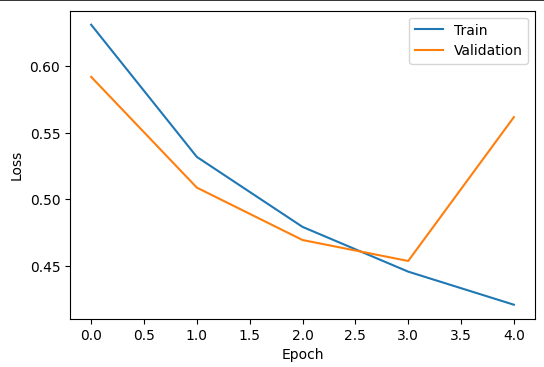

2. Treinando a rede com:
  
  i. Dataset de 800000 imagens
  
  ii. Batchsize de 128


Observamos que com o aumento do tamanho do dataset, a acurácia atingiu valores maiores (chegando ao seu pico de 80%). Isso também ocorreu na quarta época, com um comportamento oscilante de overfitting sendo observado após. Ou seja, após a quarta época, a loss de treinamento continuou diminuindo, mas a acurácia e a loss de teste permanceram oscilantes, com um período curto, constante.

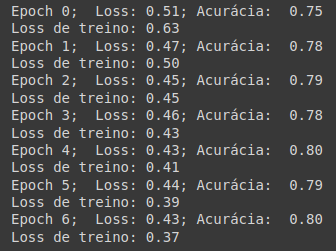


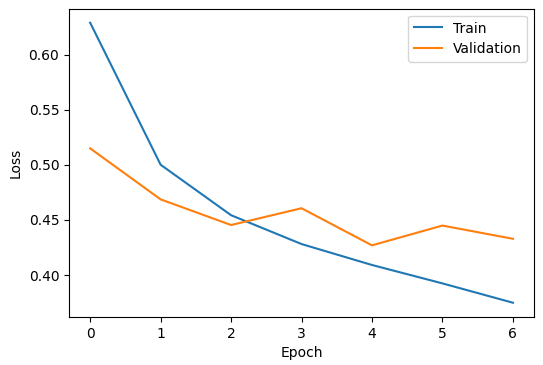

Por fim, nos atentamos a uma característica no artigo que até então havia passado desapercebida. Essa sendo o ajuste feito no passo de otimização (learning rate), o qual é ajustado - tendo seu valor diminuído pela metade, a cada três épocas.
Aparentemente, seria algo para realizar um ajuste mais fino, se aproximando mais de uma solução idela ao passo que o treinamento da rede avança.


No entanto, uma melhoria significativa não foi observada após esse ajuste. Porém, ainda assim, essa última implementação foi mantida como versão final por ser a mais fiel ao artigo original.

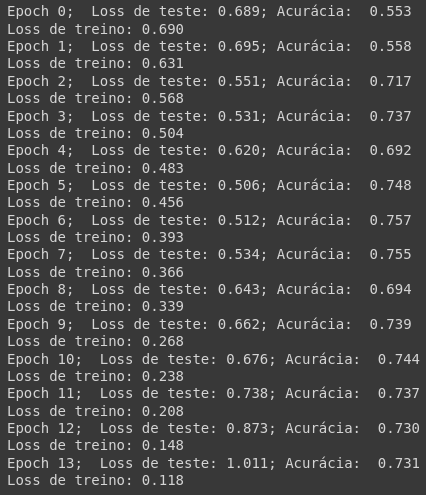

Obs: Esses resultados foram obtidos rodando o código abaixo, com um dataset de 200000 dados e batchsize 128. Podemos rodar novamente com um número arbitrário de épocas e observar um comportamento muito parecido com os já mencionados anteriormente.


Podemos rodar com um número de épocas > 4 arbitrário e um dataset de tamanho suficientemente grande que teremos um comportamento análogo:

Rodando com 100000 amostras de tweets:



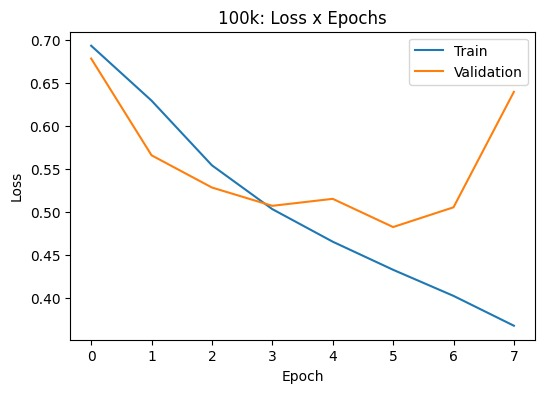

O código abaixo está disponível para testes.

É importante ressaltar que, em todos os casos, utilizamos os hiperparâmetros da arquitetura do modelo revelada no artigo: 6 camadas convolucionais e suas especificidades, 3 camadas densas e suas especificidades, dropout de 0.5, momento de 0.9, learning rate inicial de 0.1

Apesar dessas estratégias de regularização (dropout, ajuste de lr, ...) presentes na arquitetura do modelo, foi observado um comportamento de overfitting bem precoce nos dados - apesar da acurácia satsifatória.

Isso pode ser devido à própria arquitetura do modelo - e sua característica de tratar a língua como se fosse uma sequência de sinais no tempo, fazendo uma análise a nível de caractere - ou então ao dataset de tweets (textos curtos, com contextos muito variados.)

In [ ]:
n_epochs = 15

hist_tr = []
hist_te = []
hist_acc = []

for epoch in range(n_epochs):
    aux_loss = 0
    for inputs, labels in trainloader:

        model.train()
        inputs, labels  = inputs.to(device), labels.to(device)

        # Passo forward na rede
        y_hat = model(inputs)
        loss = loss_fn(y_hat, labels)


        optimizer.zero_grad() # zerando os gradientes acumulados
        loss.backward() # computando o grafo de gradientes com os valores da loss
        optimizer.step() # otimizando

        aux_loss += float(loss)

    hist_tr.append(aux_loss/len(trainloader)) # armazenamos um histórico com a loss de treinamento

    acc = 0
    aux_loss = 0
    for inputs, labels in testloader:

        model.eval()
        inputs, labels  = inputs.to(device), labels.to(device)


        with torch.no_grad():
          y_hat = model(inputs)
          loss = loss_fn(y_hat, labels)

        acc += (torch.argmax(y_hat,1) == labels).float().sum() # armazenando a acurácia do batch

        aux_loss += float(loss)

    hist_te.append(aux_loss/len(testloader)) # histórico de loss do teste
    hist_acc.append(acc/len(testloader.dataset)) # histórico de acurácia

    scheduler.step() # a cada 3 épocas, o passo é reduzido pela metade

    print("Epoch %d;  Loss de teste: %.3f; Acurácia:  %.3f" % (epoch, hist_te[-1] ,  hist_acc[-1]))
    print("Loss de treino: %.3f" % hist_tr[-1])




Epoch 0;  Loss de teste: 0.689; Acurácia:  0.553
Loss de treino: 0.690
Epoch 1;  Loss de teste: 0.695; Acurácia:  0.558
Loss de treino: 0.631
Epoch 2;  Loss de teste: 0.551; Acurácia:  0.717
Loss de treino: 0.568
Epoch 3;  Loss de teste: 0.531; Acurácia:  0.737
Loss de treino: 0.504
Epoch 4;  Loss de teste: 0.620; Acurácia:  0.692
Loss de treino: 0.483
Epoch 5;  Loss de teste: 0.506; Acurácia:  0.748
Loss de treino: 0.456
Epoch 6;  Loss de teste: 0.512; Acurácia:  0.757
Loss de treino: 0.393
Epoch 7;  Loss de teste: 0.534; Acurácia:  0.755
Loss de treino: 0.366
Epoch 8;  Loss de teste: 0.643; Acurácia:  0.694
Loss de treino: 0.339
Epoch 9;  Loss de teste: 0.662; Acurácia:  0.739
Loss de treino: 0.268
Epoch 10;  Loss de teste: 0.676; Acurácia:  0.744
Loss de treino: 0.238
Epoch 11;  Loss de teste: 0.738; Acurácia:  0.737
Loss de treino: 0.208
Epoch 12;  Loss de teste: 0.873; Acurácia:  0.730
Loss de treino: 0.148
Epoch 13;  Loss de teste: 1.011; Acurácia:  0.731
Loss de treino: 0.118


In [ ]:
plt.figure(figsize = (6,4))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(len(hist_tr)), hist_tr, label = 'Train')
plt.plot(np.arange(len(hist_te)), hist_te, label = 'Validation')
plt.legend()